Our NLP objective is to use Sentiment Analysis in order to classify and undertsand differnet customer tweet reviews on different Airlines.

In [1]:
!pip install contractions

In [2]:
# install and import necessary libraries.

#!pip install contractions

import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit.

nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.
import matplotlib.pyplot as plt                         # Import plt for visualization

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\murta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\murta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\murta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
import pandas as pd
data = pd.read_csv('Tweets.csv')

In [4]:
data.shape

(14640, 15)

In [5]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
data.isnull().sum(axis=0)

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

## Data Cleaning (before EDA):

In [7]:
data2 = data.copy()

In [8]:
data2 = data2.drop("airline_sentiment_gold",axis=1)

In [9]:
data2 = data2.drop("negativereason_gold",axis=1)

In [10]:
data2 = data2.drop("tweet_coord",axis=1)

In [11]:
data2.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline', 'name',
       'retweet_count', 'text', 'tweet_created', 'tweet_location',
       'user_timezone'],
      dtype='object')

In [12]:
data2.shape

(14640, 12)

In [13]:
# for other null values, fill na can be used + / drop na 

In [14]:
data2.isnull().sum(axis=0)

tweet_id                           0
airline_sentiment                  0
airline_sentiment_confidence       0
negativereason                  5462
negativereason_confidence       4118
airline                            0
name                               0
retweet_count                      0
text                               0
tweet_created                      0
tweet_location                  4733
user_timezone                   4820
dtype: int64

- I would leave negative reason as is (nulls mean it was a choice from customers)
- negative reason confidence has zeros for no reason, could drop. nulls also hold value (could replace zeros with null or other way around)

In [15]:
# date column has an unwanted "-800" text, we check the count
len(data2[data2['tweet_created'].str.contains(' -0800')])

14640

In [16]:
data2['tweet_created'] = data2['tweet_created'].str.replace(' -0800', '')
data2.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45,NaN,Pacific Time (US & Canada)


## EDA:

In [17]:
# may not be first step for analysis
year=[]
month=[]
day=[]
hour=[]
for x in data2['tweet_created']:
    year.append(int(x.split("-")[0]))                                          #extraction of year from date column and appending into list
    month.append(int(x.split("-")[1]))                                         #extraction of month from date column and appending into list
    day.append(int(x.split("-")[2].split(" ")[0]))                            #extraction of date of the month from date column and appending into list
    hour.append(int(x.split("-")[2].split(" ")[1].split(":")[0]))              #extraction of hour of that day from date column and appending into list

data2['year']=year
data2['month']=month
data2['day']=day
data2['hour']=hour
data2.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,year,month,day,hour
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52,NaN,Eastern Time (US & Canada),2015,2,24,11
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59,NaN,Pacific Time (US & Canada),2015,2,24,11
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48,Lets Play,Central Time (US & Canada),2015,2,24,11
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36,NaN,Pacific Time (US & Canada),2015,2,24,11
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45,NaN,Pacific Time (US & Canada),2015,2,24,11


In [79]:
data2['day'].value_counts() # all tweets were on the same month and year

22    3079
23    3028
21    1557
20    1500
17    1408
19    1376
18    1344
24    1344
16       4
Name: day, dtype: int64

#### most retweeted tweet:

In [81]:
print(data2.iloc[data2['retweet_count'].idxmax()]['text'])                      # Most favorites tweet                    

usairways hr flight delay delay land even real life get plane want go home heel click


a. Plot the distribution of all tweets among each airline & plot the distribution of sentiment across all the tweets. 

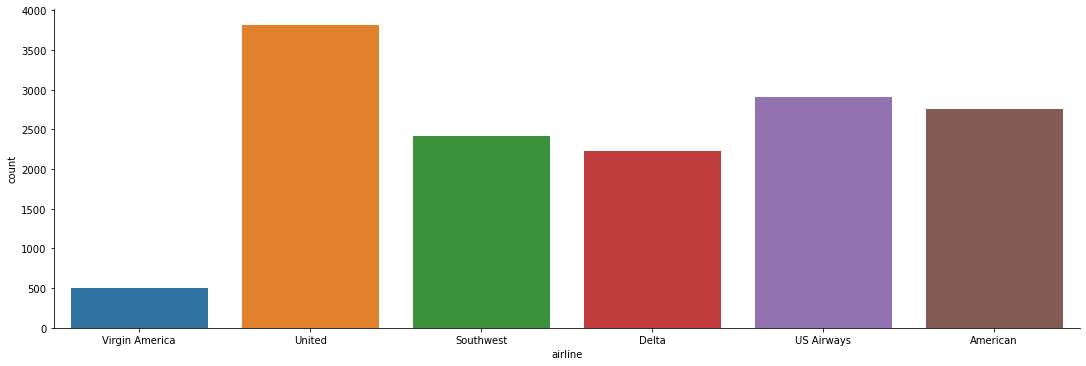

In [82]:
count_plot = sns.catplot(x='airline',data=data2,kind="count",aspect=3)

 - United has the most tweet count with about 3800 tweets, US airways and American come after.
 - Virgin America has the least tweet count with about 400 tweets
 

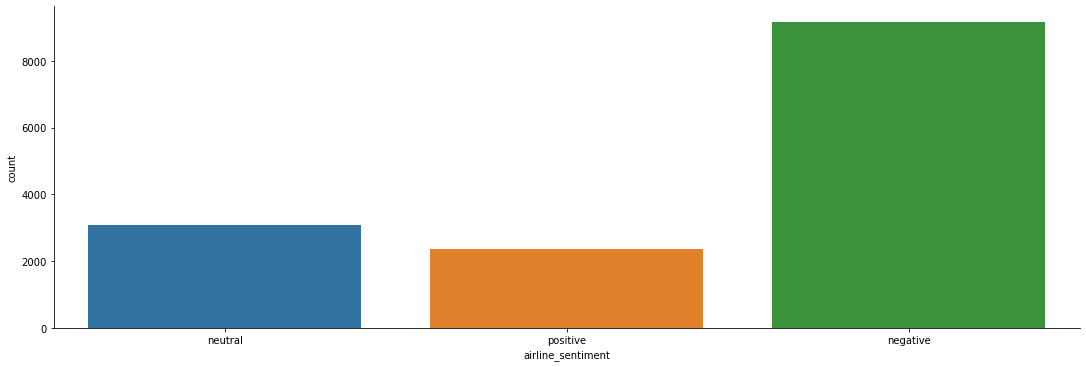

In [83]:
count_plot2 = sns.catplot(x='airline_sentiment',data=data2,kind="count",aspect=3)

- Overall, Tweet distribution is mostly comprised of negative reviews
- Positive and Negative are both between 2000 and 3000 tweets (Positive being the least)

b. Plot the distribution of Sentiment of tweets for each airline & plot the distribution of all the negative reasons. 

c. Plot the word cloud graph of tweets for positive and negative sentiment separately.

### part c was done after pre-processing (part of EDA)

### **Text Pre-processing:**

- Remove html tags.
- Replace contractions in string. (e.g. replace I'm --> I am) and so on.\
- Remove numbers.
- Tokenization
- To remove Stopwords.
- Lemmatized data

In [19]:
# I would use html parsing on text column
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")                    
    return soup.get_text()

data2['text'] = data2['text'].apply(lambda x: strip_html(x))

data2.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,year,month,day,hour
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52,NaN,Eastern Time (US & Canada),2015,2,24,11
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59,NaN,Pacific Time (US & Canada),2015,2,24,11
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48,Lets Play,Central Time (US & Canada),2015,2,24,11
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36,NaN,Pacific Time (US & Canada),2015,2,24,11
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45,NaN,Pacific Time (US & Canada),2015,2,24,11


In [20]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   name                          14640 non-null  object 
 7   retweet_count                 14640 non-null  int64  
 8   text                          14640 non-null  object 
 9   tweet_created                 14640 non-null  object 
 10  tweet_location                9907 non-null   object 
 11  user_timezone                 9820 non-null   object 
 12  year                          14640 non-null  int64  
 13  m

In [21]:
# # replace contactions for negativereason + text
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

data2['text'] = data2['text'].apply(lambda x: replace_contractions(x))
# # data2['negativereason'] = data2['negativereason'].apply(lambda x: replace_contractions(x))

data2.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,year,month,day,hour
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52,NaN,Eastern Time (US & Canada),2015,2,24,11
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you have added commercials...,2015-02-24 11:15:59,NaN,Pacific Time (US & Canada),2015,2,24,11
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I did not today... Must mean I ...,2015-02-24 11:15:48,Lets Play,Central Time (US & Canada),2015,2,24,11
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it is really aggressive to blas...,2015-02-24 11:15:36,NaN,Pacific Time (US & Canada),2015,2,24,11
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it is a really big bad thin...,2015-02-24 11:14:45,NaN,Pacific Time (US & Canada),2015,2,24,11


In [22]:
# replace null values with "ignore text" so we can use contractions function
data2.negativereason.fillna("IGNORE TEXT", inplace=True) 

In [23]:
data2.isnull().sum(axis=0)

tweet_id                           0
airline_sentiment                  0
airline_sentiment_confidence       0
negativereason                     0
negativereason_confidence       4118
airline                            0
name                               0
retweet_count                      0
text                               0
tweet_created                      0
tweet_location                  4733
user_timezone                   4820
year                               0
month                              0
day                                0
hour                               0
dtype: int64

In [24]:
data2['negativereason'] = data2['negativereason'].apply(lambda x: replace_contractions(x))
data2.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,year,month,day,hour
0,570306133677760513,neutral,1.0000,IGNORE TEXT,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52,NaN,Eastern Time (US & Canada),2015,2,24,11
1,570301130888122368,positive,0.3486,IGNORE TEXT,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you have added commercials...,2015-02-24 11:15:59,NaN,Pacific Time (US & Canada),2015,2,24,11
2,570301083672813571,neutral,0.6837,IGNORE TEXT,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I did not today... Must mean I ...,2015-02-24 11:15:48,Lets Play,Central Time (US & Canada),2015,2,24,11
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it is really aggressive to blas...,2015-02-24 11:15:36,NaN,Pacific Time (US & Canada),2015,2,24,11
4,570300817074462722,negative,1.0000,cannot Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it is a really big bad thin...,2015-02-24 11:14:45,NaN,Pacific Time (US & Canada),2015,2,24,11


In [25]:
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

data2['text'] = data2['text'].apply(lambda x: remove_numbers(x))
data2['negativereason'] = data2['negativereason'].apply(lambda x: remove_numbers(x))

data2.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,year,month,day,hour
0,570306133677760513,neutral,1.0000,IGNORE TEXT,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52,NaN,Eastern Time (US & Canada),2015,2,24,11
1,570301130888122368,positive,0.3486,IGNORE TEXT,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you have added commercials...,2015-02-24 11:15:59,NaN,Pacific Time (US & Canada),2015,2,24,11
2,570301083672813571,neutral,0.6837,IGNORE TEXT,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I did not today... Must mean I ...,2015-02-24 11:15:48,Lets Play,Central Time (US & Canada),2015,2,24,11
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it is really aggressive to blas...,2015-02-24 11:15:36,NaN,Pacific Time (US & Canada),2015,2,24,11
4,570300817074462722,negative,1.0000,cannot Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it is a really big bad thin...,2015-02-24 11:14:45,NaN,Pacific Time (US & Canada),2015,2,24,11


In [26]:
data2['text'] = data2.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # Tokenization of data
data2['negativereason'] = data2.apply(lambda row: nltk.word_tokenize(row['negativereason']), axis=1) # Tokenization of data

In [27]:
data2.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,year,month,day,hour
0,570306133677760513,neutral,1.0000,"[IGNORE, TEXT]",NaN,Virgin America,cairdin,0,"[@, VirginAmerica, What, @, dhepburn, said, .]",2015-02-24 11:35:52,NaN,Eastern Time (US & Canada),2015,2,24,11
1,570301130888122368,positive,0.3486,"[IGNORE, TEXT]",0.0000,Virgin America,jnardino,0,"[@, VirginAmerica, plus, you, have, added, com...",2015-02-24 11:15:59,NaN,Pacific Time (US & Canada),2015,2,24,11
2,570301083672813571,neutral,0.6837,"[IGNORE, TEXT]",NaN,Virgin America,yvonnalynn,0,"[@, VirginAmerica, I, did, not, today, ..., Mu...",2015-02-24 11:15:48,Lets Play,Central Time (US & Canada),2015,2,24,11
3,570301031407624196,negative,1.0000,"[Bad, Flight]",0.7033,Virgin America,jnardino,0,"[@, VirginAmerica, it, is, really, aggressive,...",2015-02-24 11:15:36,NaN,Pacific Time (US & Canada),2015,2,24,11
4,570300817074462722,negative,1.0000,"[can, not, Tell]",1.0000,Virgin America,jnardino,0,"[@, VirginAmerica, and, it, is, a, really, big...",2015-02-24 11:14:45,NaN,Pacific Time (US & Canada),2015,2,24,11


In [28]:
stopwords = stopwords.words('english')

customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# Set custom stop-word's list as not, couldn't etc. words matter in Sentiment, so not removing them from original data.

stopwords = list(set(stopwords) - set(customlist))

In [29]:
lemmatizer = WordNetLemmatizer()

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

data2['text'] = data2.apply(lambda row: normalize(row['text']), axis=1)
data2['negativereason'] = data2.apply(lambda row: normalize(row['negativereason']), axis=1)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [30]:
data2.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,year,month,day,hour
0,570306133677760513,neutral,1.0000,ignore text,NaN,Virgin America,cairdin,0,virginamerica dhepburn say,2015-02-24 11:35:52,NaN,Eastern Time (US & Canada),2015,2,24,11
1,570301130888122368,positive,0.3486,ignore text,0.0000,Virgin America,jnardino,0,virginamerica plus add commercials experience ...,2015-02-24 11:15:59,NaN,Pacific Time (US & Canada),2015,2,24,11
2,570301083672813571,neutral,0.6837,ignore text,NaN,Virgin America,yvonnalynn,0,virginamerica not today must mean need take an...,2015-02-24 11:15:48,Lets Play,Central Time (US & Canada),2015,2,24,11
3,570301031407624196,negative,1.0000,bad flight,0.7033,Virgin America,jnardino,0,virginamerica really aggressive blast obnoxiou...,2015-02-24 11:15:36,NaN,Pacific Time (US & Canada),2015,2,24,11
4,570300817074462722,negative,1.0000,not tell,1.0000,Virgin America,jnardino,0,virginamerica really big bad thing,2015-02-24 11:14:45,NaN,Pacific Time (US & Canada),2015,2,24,11


### **Word Cloud based on Summary and Score**

In [32]:
!pip install wordcloud

In [39]:
import wordcloud
def show_wordcloud3(data2, title):
    text = ' '.join(data2['text'].astype(str).tolist())                 # Converting Summary column into list
    stopwords = set(wordcloud.STOPWORDS)                                  # instantiate the stopwords from wordcloud
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='white',          # Setting the different parameter of stopwords
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(14,11), frameon=True)                             
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=30)
    plt.show()

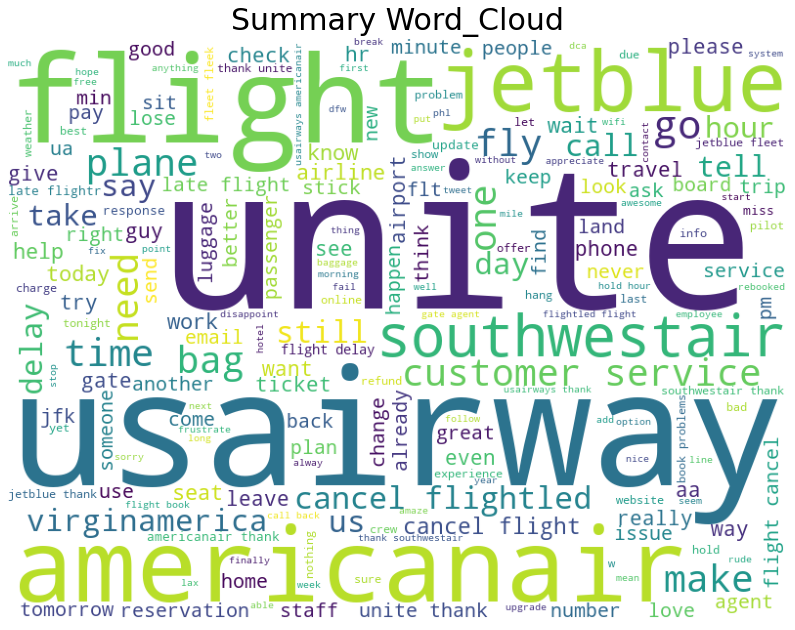

In [40]:
show_wordcloud3(data2,'Summary Word_Cloud')

- Most airlines mentioned in the text column were Jetblue, Southwest Air, USairways, American Air, and United (5 major airlines). Virgin America was not mentioned as much
- Customer Service was a trendy topic, along with 'delay' and 'cancel flight'

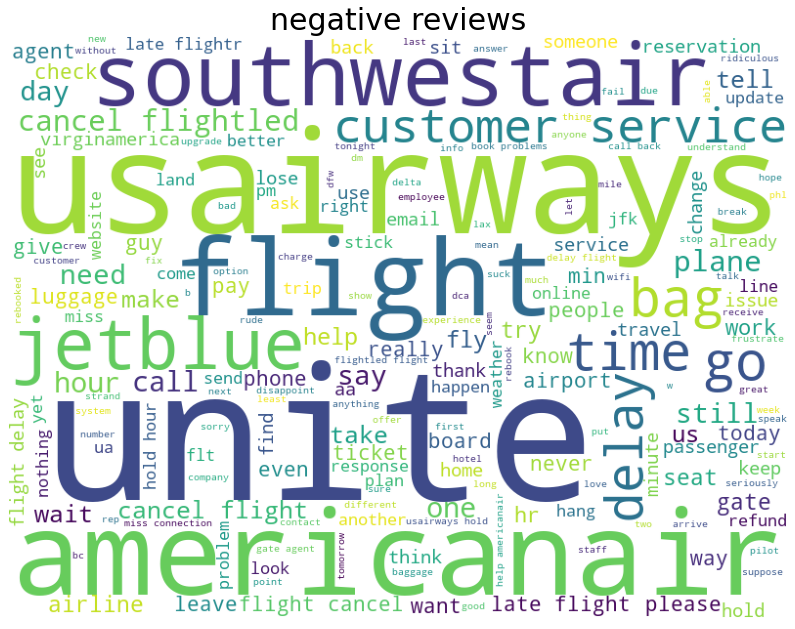

In [42]:
show_wordcloud3(data2[data2.airline_sentiment == 'negative'], title = "negative reviews")

In [45]:
# could add wordcount for negative reason or other type of analysis for that column

- Airlines mentioned in negative reviews mostly were Southwest Air, US airways, JetBlue, United, and American Air (5). Top 3 are US airways, United, and American Air.
- Passengers were mostly complaining about customer service, flight delays, flight cancellation, and late flights.

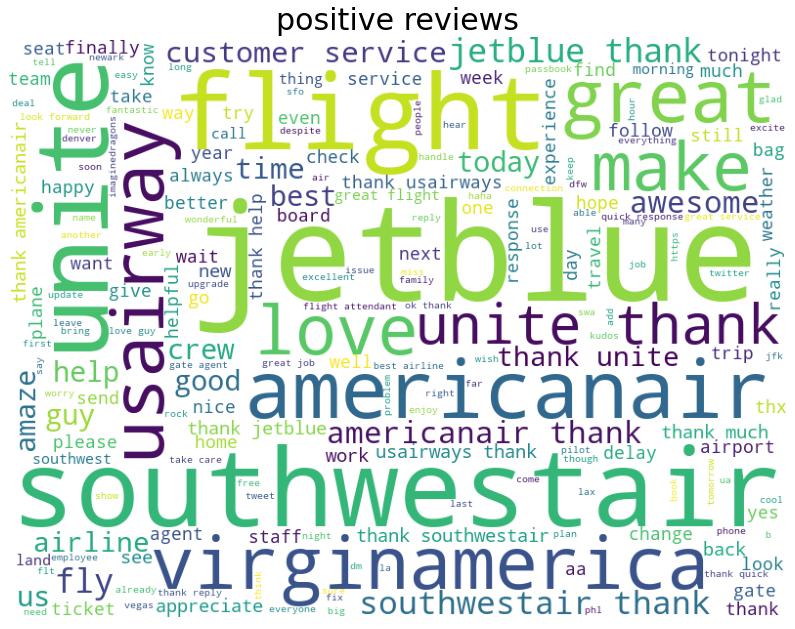

In [43]:
show_wordcloud3(data2[data2.airline_sentiment == 'positive'], title = "positive reviews")

- Most positive reviewed: JetBlue, Sothwest Air, United, US airways, and Virgin America (5).
- Virgin America was seen with very low negative reviews, and high positive reviews.
- JetBlue seems to have most positive reviews along with Southwest Air.
- Good reiews mostly about customer service, staff and crew, and helpfulness

### **Building the model based on CountVectorizer and Random Forest**

### ***5. Vectorization: (8 Marks)***
    a. Use CountVectorizer.
    b. Use TfidfVectorizer.
### ***6. Fit, tune(optimize the parameter to improve the accuracy)& evaluate the model using both types of vectorization.***
- Print the top 40 features and plot their word cloud using both types of vectorization. (14 Marks)

In [46]:
# Vectorization (Convert text data to numbers).
from sklearn.feature_extraction.text import CountVectorizer

bow_vec = CountVectorizer(max_features=2000)                # Keep only 2000 features as number of features will increase the processing time.
data_features = bow_vec.fit_transform(data2['text'])

data_features = data_features.toarray()                        # Convert the data features to array.

In [47]:
data_features.shape

(14640, 2000)

In [48]:
data2['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [49]:
# creating score column for labeling
data2['score'] = [0 if x=='negative' else 0.5 if x=='neutral' else 1 for x in data2['airline_sentiment']]
data2.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,year,month,day,hour,score
0,570306133677760513,neutral,1.0000,ignore text,NaN,Virgin America,cairdin,0,virginamerica dhepburn say,2015-02-24 11:35:52,NaN,Eastern Time (US & Canada),2015,2,24,11,0.5
1,570301130888122368,positive,0.3486,ignore text,0.0000,Virgin America,jnardino,0,virginamerica plus add commercials experience ...,2015-02-24 11:15:59,NaN,Pacific Time (US & Canada),2015,2,24,11,1.0
2,570301083672813571,neutral,0.6837,ignore text,NaN,Virgin America,yvonnalynn,0,virginamerica not today must mean need take an...,2015-02-24 11:15:48,Lets Play,Central Time (US & Canada),2015,2,24,11,0.5
3,570301031407624196,negative,1.0000,bad flight,0.7033,Virgin America,jnardino,0,virginamerica really aggressive blast obnoxiou...,2015-02-24 11:15:36,NaN,Pacific Time (US & Canada),2015,2,24,11,0.0
4,570300817074462722,negative,1.0000,not tell,1.0000,Virgin America,jnardino,0,virginamerica really big bad thing,2015-02-24 11:14:45,NaN,Pacific Time (US & Canada),2015,2,24,11,0.0


In [50]:
# checking score counts and datatype
data2['score'].value_counts()

0.0    9178
0.5    3099
1.0    2363
Name: score, dtype: int64

In [56]:
labels = data2['score']
labels = labels.astype('int')

In [57]:
# Split data into training and testing set.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_features, labels, test_size=0.3, random_state=42)

In [58]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, data_features, labels, cv=10)))

RandomForestClassifier(n_estimators=10, n_jobs=4)
0.8739754098360656


- High score of 87% is great but could be an effect of having three values for our labels

### **Optimizing the parameter: Number of trees in the random forest model(n_estimators)**

In [59]:

# Finding optimal number of base learners using k-fold CV ->
base_ln = [x for x in range(1, 25)]
base_ln

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

In [60]:
# K-Fold Cross - validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

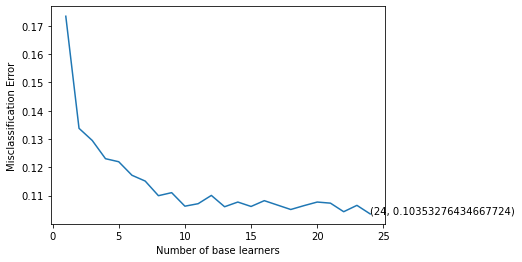

In [61]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]                                 #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                           #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [62]:
# Training the best model and calculating accuracy on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9039162112932605

- After tuning, we have a 3 percent increase in accuracy

In [63]:
result =  clf.predict(X_test)                  #saving the prediction on test data as a result

In [66]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, result)

print(conf_mat)

print(metrics.f1_score(y_test, result,average='micro'))

[[3579  119]
 [ 303  391]]
0.9039162112932605


### **Word Cloud of top 40 important features from the CountVectorizer + Random Forest based model**

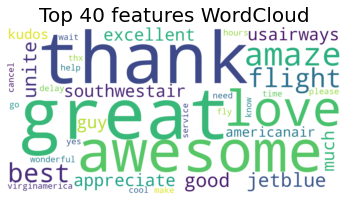

In [67]:
all_features = bow_vec.get_feature_names()              #Instantiate the feature from the vectorizer
top_features=''                                            # Addition of top 40 feature into top_feature after training the model
feat=clf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=' '
    
    

from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

### **Term Frequency(TF) - Inverse Document Frequency(IDF)**

In [68]:
# Using TfidfVectorizer to convert text data to numbers.

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2000)
data_featuresTF = vectorizer.fit_transform(data2['text'])

data_featuresTF = data_featuresTF.toarray()

data_featuresTF.shape

(14640, 2000)

In [69]:
# Split data into training and testing set.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_featuresTF, labels, test_size=0.3, random_state=42)

In [70]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

forestTF = RandomForestClassifier(n_estimators=10, n_jobs=4)

forestTF = forestTF.fit(X_train, y_train)

print(forestTF)

print(np.mean(cross_val_score(forestTF, data_featuresTF, labels, cv=5)))

RandomForestClassifier(n_estimators=10, n_jobs=4)
0.7907786885245901


- score is less than the original model by 8 perecent

In [71]:
# K - Fold Cross Validation .
cv_scores = []
for b in base_ln:
    clfTF = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clfTF, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

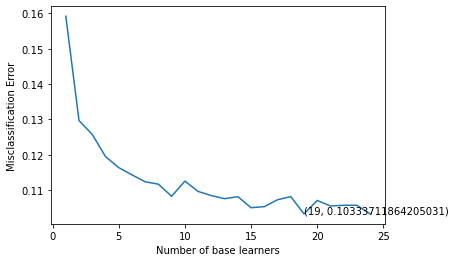

In [72]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]                                              #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                             #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                                        #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [73]:
# Training the best model and calculating error on test data .
clfTF = RandomForestClassifier(n_estimators = optimal_learners)
clfTF.fit(X_train, y_train)
clfTF.score(X_test, y_test)

0.9052823315118397

- tuned model is slightly better than tuned count vectorizer by about 0.02%

In [74]:
resultTF = clfTF.predict(X_test)

In [75]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

conf_matTF = confusion_matrix(y_test, result)

print(conf_matTF)

print(metrics.f1_score(y_test, resultTF,average='micro'))

[[3579  119]
 [ 303  391]]
0.9052823315118397


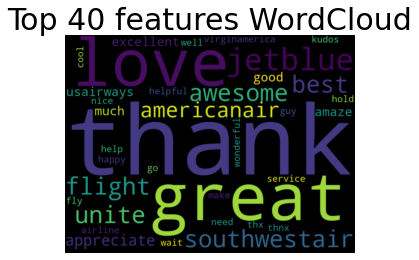

In [76]:
all_features = vectorizer.get_feature_names()                                #Instantiate the feature from the vectorizer
Top_features=''                                                              #Addition of top 40 feature into top_feature after training the model
feat=clfTF.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    Top_features+=all_features[i]
    Top_features+=' '
    
  
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="Black",width=1000, 
                          height=750).generate(Top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(30, 30), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=30)
plt.axis("off")
plt.show()

## ***Summary:***
- We used a dataset which has reviews in text format and created a score column from 0 to 1 based on the sentiment existing column
- our goal was to classify the sentiments of the reviews
- data was pre-processed usig multiple techniques
- Model was trained and tuned using Count Vectroizer and TFIDf, two models had about the same accuracy
- Accuracy was very good at 90%
- Other model hyperprametert tuning could be used to further increase the overall accuracy, with more pre-processing as well